http://www.sidra.ibge.gov.br/bda/tabela/listabl.asp?z=t&o=22&i=P&c=3653

https://dadosdadosdados.wordpress.com/2015/09/25/trabalhando-com-series-temporais-no-r-parte-i-2/

In [1006]:
%matplotlib inline
from unidecode import unidecode
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2, activity_l2

from sklearn.metrics import r2_score

In [1007]:
dataset = pd.read_csv('PIN.csv', sep=';', skiprows=3,header=1,skipfooter=1, engine='python', encoding='ISO-8859-1')
dataset.columns = [unidecode(x) for x in dataset.columns]

In [1008]:
dataset.columns

Index([u'Unnamed: 0', u'Brasil', u'Amazonas', u'Para', u'Ceara', u'Pernambuco',
       u'Bahia', u'Minas Gerais', u'Espirito Santo', u'Rio de Janeiro',
       u'Sao Paulo', u'Parana', u'Santa Catarina', u'Rio Grande do Sul',
       u'Mato Grosso', u'Goias'],
      dtype='object')

In [1009]:
for c in dataset.columns[1:]:
    dataset[c] = dataset[c].str.replace(',','.').replace('-',np.nan).astype(float)


In [1010]:
dataset.head()

,Unnamed: 0,Brasil,Amazonas,Para,Ceara,Pernambuco,Bahia,Minas Gerais,Espirito Santo,Rio de Janeiro,Sao Paulo,Parana,Santa Catarina,Rio Grande do Sul,Mato Grosso,Goias
0,janeiro 2002,72.4,59.1,53.0,89.7,77.9,81.1,73.0,67.1,83.4,68.6,55.2,90.0,85.4,NaN,48.2
1,fevereiro 2002,69.7,57.9,55.1,80.2,66.3,72.4,66.8,61.5,77.3,68.0,56.2,89.4,84.3,NaN,55.8
2,março 2002,77.4,65.5,61.6,88.0,67.0,78.3,75.7,62.9,84.8,74.8,62.2,93.8,98.8,NaN,62.3
3,abril 2002,79.6,73.7,59.3,90.6,67.7,75.0,72.7,66.8,86.9,76.8,65.1,98.3,108.2,NaN,63.4
4,maio 2002,80.4,66.7,58.8,90.4,67.8,72.4,74.8,67.8,88.3,79.6,62.7,96.2,109.8,NaN,63.8


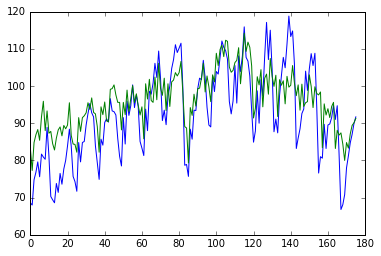

In [1011]:
plt.plot(dataset['Sao Paulo'])
plt.plot(dataset['Rio de Janeiro'])
#plt.plot(dataset['Rio Grande do Sul'])

In [1012]:
# fix random seed for reproducibility
numpy.random.seed(42)

In [1013]:
# load the dataset
# remove columns
#del dataset['Unnamed: 0']
del dataset['Brasil']

### Clean data and convert dates

In [1014]:
def date_convertator(series):
    months = {'janeiro':'01',
              'fevereiro':'02',
              'marco':'03',
              'abril':'04',
              'maio':'05',
              'junho':'06',
              'julho':'07',
              'agosto':'08',
              'setembro':'09',
              'outubro':'10',
              'novembro':'11',
              'dezembro':'12'}

    dates = series.str.split(' ', expand=True)
    dates[0] = dates[0].apply(lambda x: unidecode(x))
    for key, value in months.iteritems():

        dates[0] = dates[0].str.replace(key, value)

    date_vec = pd.to_datetime(dates[1]+ '-' + dates[0])
    return date_vec

In [1015]:
dataset['Date'] = date_convertator(dataset['Unnamed: 0'])
del dataset['Unnamed: 0']

In [1016]:
dataset.head()

,Amazonas,Para,Ceara,Pernambuco,Bahia,Minas Gerais,Espirito Santo,Rio de Janeiro,Sao Paulo,Parana,Santa Catarina,Rio Grande do Sul,Mato Grosso,Goias,Date
0,59.1,53.0,89.7,77.9,81.1,73.0,67.1,83.4,68.6,55.2,90.0,85.4,NaN,48.2,2002-01-01
1,57.9,55.1,80.2,66.3,72.4,66.8,61.5,77.3,68.0,56.2,89.4,84.3,NaN,55.8,2002-02-01
2,65.5,61.6,88.0,67.0,78.3,75.7,62.9,84.8,74.8,62.2,93.8,98.8,NaN,62.3,2002-03-01
3,73.7,59.3,90.6,67.7,75.0,72.7,66.8,86.9,76.8,65.1,98.3,108.2,NaN,63.4,2002-04-01
4,66.7,58.8,90.4,67.8,72.4,74.8,67.8,88.3,79.6,62.7,96.2,109.8,NaN,63.8,2002-05-01


### Get % variation

In [1017]:
dataset.ix[:,:-1] = dataset.ix[:,:-1]/dataset.shift(1).ix[:,:-1]-1

In [1019]:
dataset = pd.melt(dataset.groupby('Date').sum().reset_index(),id_vars='Date')
dataset.head()

,Date,variable,value
0,2002-01-01,Amazonas,NaN
1,2002-02-01,Amazonas,-0.020305
2,2002-03-01,Amazonas,0.131261
3,2002-04-01,Amazonas,0.125191
4,2002-05-01,Amazonas,-0.094980


### Add Seasonal factor

In [1020]:
dataset['month'] = pd.DatetimeIndex(dataset['Date']).month

In [1021]:
dataset[dataset['variable']=='Sao Paulo'].head()

,Date,variable,value,month
1408,2002-01-01,Sao Paulo,NaN,1
1409,2002-02-01,Sao Paulo,-0.008746,2
1410,2002-03-01,Sao Paulo,0.100000,3
1411,2002-04-01,Sao Paulo,0.026738,4
1412,2002-05-01,Sao Paulo,0.036458,5


In [1022]:
def laggator(df, feature='value', index='Date', columns='variable', prefix='L', lags=12):
    df = df.ix[:,[index, columns, feature]]
    data = np.zeros((df.shape[0],lags))
    for l in range(1,lags+1):
        data[:,l-1] = pd.melt(df.pivot(index=index,columns=columns,values=feature).shift(l).reset_index(), id_vars=index)['value']
    
    datadf = pd.DataFrame(data)
    colnames = [feature + str(x+1) for x in range(lags)]
    datadf.columns = colnames
    
    return datadf, colnames

In [1023]:
LAGS = 12
FEATURE = ['value', 'month']
INDEX = 'Date'
COLUMNS = 'variable'
feat_names = []
data = []

for f in FEATURE:
    dt, colnames = laggator(dataset, feature=f, index=INDEX, columns=COLUMNS, lags=LAGS)
    feat_names.append(colnames)
    data.append(dt)
#data = data.fillna(0)
#pd.concat([dataset, data])
#true_val = data['value']
#del data['value']

In [1024]:
new_data = pd.concat([dataset,pd.concat(data,axis=1)],axis=1)

In [1025]:
new_data.ix[new_data.variable=='Sao Paulo',:].head()

,Date,variable,value,month,value1,value2,value3,value4,value5,value6,...,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
1408,2002-01-01,Sao Paulo,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1409,2002-02-01,Sao Paulo,-0.008746,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1410,2002-03-01,Sao Paulo,0.100000,3,0.018116,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1411,2002-04-01,Sao Paulo,0.026738,4,0.106762,0.018116,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1412,2002-05-01,Sao Paulo,0.036458,5,0.046624,0.106762,0.018116,NaN,NaN,NaN,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1026]:
CUTOFF = '2015-01-01'

In [1027]:
train = new_data.ix[new_data['Date']<CUTOFF,:].fillna(0)
test = new_data.ix[new_data['Date']>=CUTOFF,:].fillna(0)

In [1028]:
train.head()

,Date,variable,value,month,value1,value2,value3,value4,value5,value6,...,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
0,2002-01-01,Amazonas,0.000000,1,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2002-02-01,Amazonas,-0.020305,2,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2002-03-01,Amazonas,0.131261,3,-0.020305,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2002-04-01,Amazonas,0.125191,4,0.131261,-0.020305,0.000000,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2002-05-01,Amazonas,-0.094980,5,0.125191,0.131261,-0.020305,0.0,0.0,0.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Shape data for Keras

In [1029]:
FEAT = len(FEATURE)
traX = np.zeros((train.shape[0], LAGS, FEAT))
tesX = np.zeros((test.shape[0], LAGS, FEAT))
traY = np.zeros((train.shape[0]))
tesY = np.zeros((test.shape[0]))

for f in range(features):
    traX[:,:,f] = train.ix[:, feat_names[f]]
    tesX[:,:,f] = test.ix[:, feat_names[f]]

traY = train['value']
tesY = test['value']

In [1030]:
traX.shape, traY.shape

((2184, 12, 2), (2184,))

In [1031]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_dim=traX.shape[2], return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(128,return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(12))
#model.add(Flatten())
model.add(Dense(1, W_regularizer=l2(1e-6), activity_regularizer=activity_l2(1e-6)))
model.compile(loss='mean_squared_error', optimizer='rmsprop')

hist = model.fit(traX, traY, nb_epoch=60, batch_size=1, verbose=2, validation_split=0.3)

Train on 1528 samples, validate on 656 samples
Epoch 1/60
11s - loss: 0.0065 - val_loss: 0.0051
Epoch 2/60
10s - loss: 0.0057 - val_loss: 0.0054
Epoch 3/60
10s - loss: 0.0057 - val_loss: 0.0050
Epoch 4/60
10s - loss: 0.0056 - val_loss: 0.0052
Epoch 5/60
10s - loss: 0.0054 - val_loss: 0.0059
Epoch 6/60
14s - loss: 0.0055 - val_loss: 0.0056
Epoch 7/60
13s - loss: 0.0054 - val_loss: 0.0058
Epoch 8/60
10s - loss: 0.0054 - val_loss: 0.0054
Epoch 9/60
10s - loss: 0.0053 - val_loss: 0.0063
Epoch 10/60
11s - loss: 0.0052 - val_loss: 0.0059
Epoch 11/60
12s - loss: 0.0053 - val_loss: 0.0050
Epoch 12/60
11s - loss: 0.0051 - val_loss: 0.0057
Epoch 13/60
11s - loss: 0.0052 - val_loss: 0.0050
Epoch 14/60
10s - loss: 0.0051 - val_loss: 0.0052
Epoch 15/60
12s - loss: 0.0050 - val_loss: 0.0053
Epoch 16/60
12s - loss: 0.0049 - val_loss: 0.0053
Epoch 17/60
12s - loss: 0.0048 - val_loss: 0.0048
Epoch 18/60
11s - loss: 0.0046 - val_loss: 0.0056
Epoch 19/60
11s - loss: 0.0046 - val_loss: 0.0055
Epoch 20/60


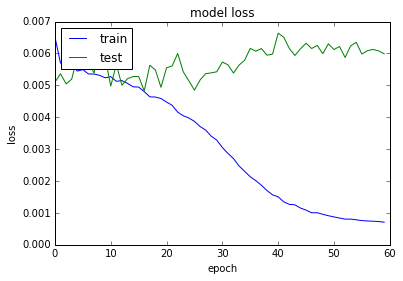

In [1032]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [1033]:
# generate predictions for training
trainPredict = model.predict(traX)
testPredict = model.predict(tesX)

In [1036]:
trainPredict.shape, testPredict.shape

((2184, 1), (280, 1))

In [1037]:
final = dataset[['Date', 'variable']]
final.ix[:, 'true_val'] = true_val
final.ix[final['Date']<CUTOFF, 'train_pred'] = trainPredict
final.ix[final['Date']>=CUTOFF, 'test_pred'] = testPredict
final['train'] = final['true_val'] * (1+final['train_pred'])
final['test'] = final['true_val'] * (1+final['test_pred'])

In [1038]:
final[final['variable']=='Sao Paulo'].head()

,Date,variable,true_val,train_pred,test_pred,train,test
1408,2002-01-01,Sao Paulo,68.6,-0.013033,NaN,67.705966,NaN
1409,2002-02-01,Sao Paulo,68.0,-0.013033,NaN,67.113785,NaN
1410,2002-03-01,Sao Paulo,74.8,0.068402,NaN,79.916456,NaN
1411,2002-04-01,Sao Paulo,76.8,0.044438,NaN,80.212807,NaN
1412,2002-05-01,Sao Paulo,79.6,0.059086,NaN,84.303224,NaN


In [1040]:
dataset.variable.unique()

array(['Amazonas', 'Para', 'Ceara', 'Pernambuco', 'Bahia', 'Minas Gerais',
       'Espirito Santo', 'Rio de Janeiro', 'Sao Paulo', 'Parana',
       'Santa Catarina', 'Rio Grande do Sul', 'Mato Grosso', 'Goias'], dtype=object)

In [1059]:
# plot baseline and predictions
f1 = (final['Date']<CUTOFF)
f2 = (final['Date']>=CUTOFF)
print 'Full data R squared'
print 'Train set - ' + str(r2_score(final.ix[f1,'true_val'],final.ix[f1,'train']))
print 'Test set - ' + str(r2_score(final.ix[f2,'true_val'],final.ix[f2,'test']))


Full data R squared
Train set - 0.922800272334
Test set - 0.853862280624


In [1060]:
est = []
tr = []
te = []
for e in final['variable'].unique():
    f1 = (final['variable']==e) & (final['Date']<CUTOFF)
    f2 = (final['variable']==e) & (final['Date']>=CUTOFF)
    
    est.append(e)
    tr.append(r2_score(final.ix[f1,'true_val'],final.ix[f1,'train']))
    te.append(r2_score(final.ix[f2,'true_val'],final.ix[f2,'test']))

print 'R squared by state'
pd.DataFrame({'estado':est, 'train-R2':tr, 'test-R2':te})[['estado', 'train-R2', 'test-R2']]
    

R squared by state


,estado,train-R2,test-R2
0,Amazonas,0.405056,0.600166
1,Para,0.783183,0.662874
2,Ceara,0.441514,0.346183
3,Pernambuco,0.664008,0.852263
4,Bahia,0.457361,0.593417
5,Minas Gerais,0.895117,0.566588
6,Espirito Santo,0.784952,0.843140
7,Rio de Janeiro,0.397959,-0.754884
8,Sao Paulo,0.664726,0.791995
9,Parana,0.768552,0.678695


Pernambuco 0.664008027899 0.852263425545


''

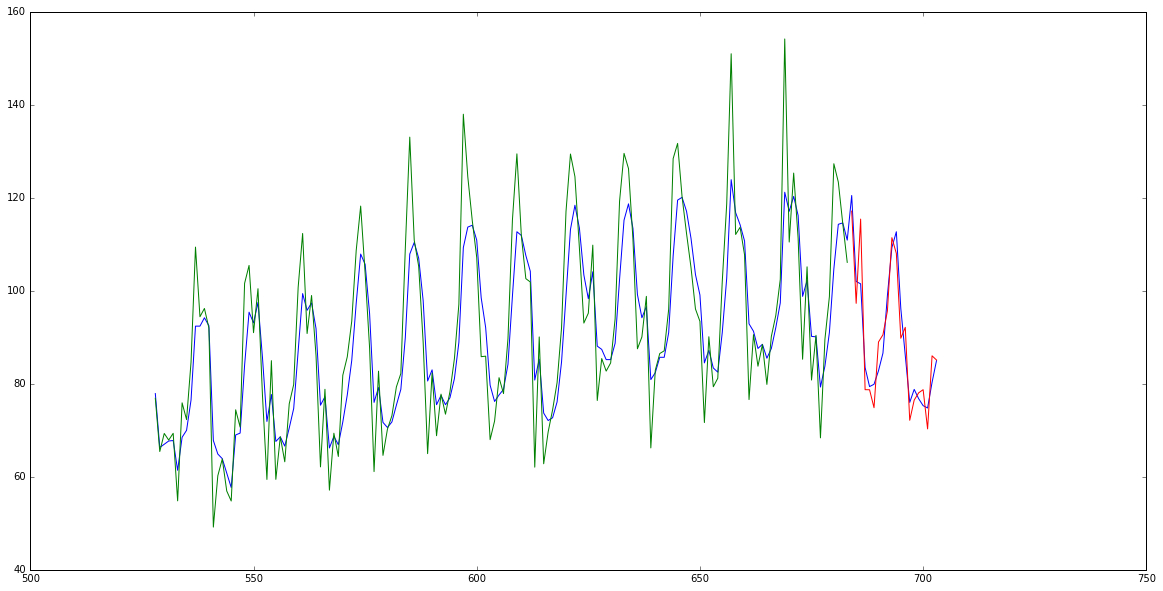

In [1045]:
# plot baseline and predictions
estado = 'Pernambuco'
f1 = (final['variable']==estado) & (final['Date']<CUTOFF)
f2 = (final['variable']==estado) & (final['Date']>=CUTOFF)

print estado, r2_score(final.ix[f1,'true_val'],final.ix[f1,'train']), r2_score(final.ix[f2,'true_val'],final.ix[f2,'test'])

plt.figure(figsize=(20,10))
plt.plot(final.ix[final['variable']==estado, 'true_val'])
plt.plot(final.ix[final['variable']==estado, 'train'])
plt.plot(final.ix[final['variable']==estado, 'test'])
''